## 1. Create recommender system.

> ### Load Data 

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from fuzzywuzzy import fuzz

C:\Users\Abhi\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
links=pd.read_csv('links.csv')

In [3]:
movies=pd.read_csv('movies.csv')

In [4]:
ratings=pd.read_csv('ratings.csv')

In [5]:
tag=pd.read_csv('tags.csv')


In [6]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
movies.head()




,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
tag.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
num_users = len(ratings.userId.unique())
num_items = len(ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this data set


### DataPreprocessing




The trend in average ratings for different movie genres: How the average ratings for a few different movie genres (namely, Animation, Comedy, Romance, Thriller, Horror,
Sci-Fi and Musical) change over time (different years, from 1995 to 2018)? How can the average ratings for different genres be compared among themselves?

In [11]:
x=movies['genres'].astype('str').str.split("|")
y=[]
for i in x: 
    y.append(i[0])

In [12]:
movies['genres']=pd.Series(y)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
1,2,Jumanji (1995),Adventure
2,3,Grumpier Old Men (1995),Comedy
3,4,Waiting to Exhale (1995),Comedy
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
import time
ratings['year'] = ratings['timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings.head()

,userId,movieId,rating,timestamp,year
0,1,1,4.0,964982703,2000
1,1,3,4.0,964981247,2000
2,1,6,4.0,964982224,2000
3,1,47,5.0,964983815,2000
4,1,50,5.0,964982931,2000


In [14]:
ratings1= ratings.merge(movies, left_on='movieId', right_on='movieId', how='inner')
ratings1.head()

,userId,movieId,rating,timestamp,year,title,genres
0,1,1,4.0,964982703,2000,Toy Story (1995),Adventure
1,5,1,4.0,847434962,1996,Toy Story (1995),Adventure
2,7,1,4.5,1106635946,2005,Toy Story (1995),Adventure
3,15,1,2.5,1510577970,2017,Toy Story (1995),Adventure
4,17,1,4.5,1305696483,2011,Toy Story (1995),Adventure


In [15]:
ratings1.shape

(100836, 7)

In [16]:
ratings1 = ratings1.loc[ratings1['genres'].isin(['Sci-Fi', 'Animation', 'Comedy', 'Romance', 'Thriller', 'Horror', 'Musical'])]

In [17]:
ratings2 = ratings1.groupby(['movieId', 'year', 'genres'], as_index=False)['rating'].aggregate(np.mean)
ratings2.head()

,movieId,year,genres,rating
0,3,1996,Comedy,3.833333
1,3,1997,Comedy,3.300000
2,3,2000,Comedy,2.857143
3,3,2001,Comedy,4.333333
4,3,2002,Comedy,3.000000


In [18]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,12.27)})
y=sns.lineplot(x='year',y='rating',hue="genres",err_style="bars", ci=20,data=ratings2).set_title('Trend in Average movie ratings for Different Genre')

#### The next figure shows the trends of the ratings (averaged over users and movies for each genre) for different genres across different year.

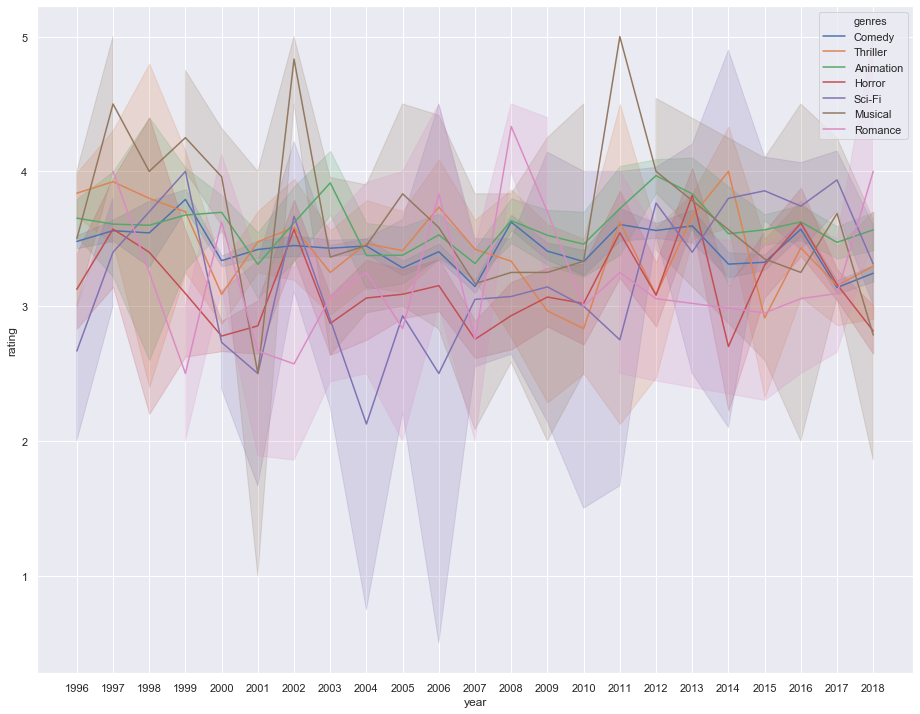

In [19]:
sns.set(rc={'figure.figsize':(15.7,12.27)})

sns.lineplot(x='year',y='rating',hue="genres"
             ,data=ratings1)

In [20]:
# get rating frequency
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100836, 5)
shape of ratings data after dropping unpopular movies:  (41360, 5)


In [21]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,117
2,15
3,6
4,84
5,34


In [22]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 5)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 5)


> ### Train KNN model for item-based collaborative filtering

1. Reshaping the Data

In [23]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)
movie_user_mat_sparse

<450x268 sparse matrix of type '<class 'numpy.float64'>'
	with 32999 stored elements in Compressed Sparse Row format>

2.Fitting the model

In [24]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

> ### Use this trained model to make movie recommendations to myself

In [25]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [26]:
my_favorite = input()

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

toy story
You have input movie: toy story
Found possible matches in our database: ['Toy Story (1995)', 'Toy Story 3 (2010)', 'Toy Story 2 (1999)']

Recommendation system start to make inference
......

Recommendations for toy story:
1: Back to the Future (1985), with distance of 0.3423310709685232
2: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.3406687641315801
3: Apollo 13 (1995), with distance of 0.3377813877372813
4: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with distance of 0.3348625521441898
5: Shrek (2001), with distance of 0.3334433995717677
6: Pulp Fiction (1994), with distance of 0.33281778682539587
7: Star Wars: Episode VI - Return of the Jedi (1983), with distance of 0.3267058482475984
8: Star Wars: Episode IV - A New Hope (1977), with distance of 0.32584484119025636
9: Forrest Gump (1994), with distance of 0.3068103361462835
10: Jurassic Park (1993), with distance of 0.2797789115289834


##  <span style="color:blue">2.Display predicted rating for a particular userID and MovieID combinations (both taken as keyboard input)

In [27]:
reader= Reader(rating_scale=(1,5))
data=Dataset.load_from_df(ratings[['userId','movieId','rating']],reader)
[trainset, testset]=train_test_split(data,test_size=.25,shuffle=True)
recom=KNNWithMeans(k=50,sim_options={'name':'cosine','user_based':True})
recom.fit(data.build_full_trainset())
test_pred=recom.test(testset)
RMSE=accuracy.rmse(test_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7717


In [28]:
user=int(input("Enter the UserId: "))
movie=int(input("Enter the MovieId: "))
pre = recom.predict(user,movie)
print('The rating value for Movieid ' + str(movie) + ' by user ' + str(user) + ' is ', pre[3])

Enter the UserId: 25
Enter the MovieId: 75
The rating value for Movieid 75 by user 25 is  3.4706429418051625


## <span style="color:green">3. Recommend a user to watch top 10 movies, which has not watched yet (as per his rating predictions). Take userID as a keyboard input. Fix the threshold rating as 2.5</span>

In [29]:
merge_movie_links = links.merge(movies, on="movieId", how='left')
merge_movie_links.shape

(9742, 5)

In [30]:
merge_movie_links.head()


,movieId,imdbId,tmdbId,title,genres
0,1,114709,862.0,Toy Story (1995),Adventure
1,2,113497,8844.0,Jumanji (1995),Adventure
2,3,113228,15602.0,Grumpier Old Men (1995),Comedy
3,4,114885,31357.0,Waiting to Exhale (1995),Comedy
4,5,113041,11862.0,Father of the Bride Part II (1995),Comedy


In [31]:
Avg_user_rating=ratings.groupby("movieId")['rating'].mean().reset_index()
Avg_user_rating.rename(columns = {"rating":"Avg_Rating"}, 
                                 inplace = True)
Avg_user_rating.shape

(9724, 2)

In [32]:
merge_ratings_Avg_user_rating = Avg_user_rating.merge(merge_movie_links, on="movieId", how='left')
merge_ratings_Avg_user_rating.head()

,movieId,Avg_Rating,imdbId,tmdbId,title,genres
0,1,3.920930,114709,862.0,Toy Story (1995),Adventure
1,2,3.431818,113497,8844.0,Jumanji (1995),Adventure
2,3,3.259615,113228,15602.0,Grumpier Old Men (1995),Comedy
3,4,2.357143,114885,31357.0,Waiting to Exhale (1995),Comedy
4,5,3.071429,113041,11862.0,Father of the Bride Part II (1995),Comedy


In [33]:
from collections import Counter

userid=int(input("Enter the UserId: "))

def recommend(userid):
    movie_list={}
    
    # creating empty dictionary using userid as key and movieid as value
    for movieid in merge_ratings_Avg_user_rating['movieId']:
        if recom.predict(userid,movieid)[3] > 2.5:
            movie_list[movieid] = recom.predict(userid,movieid)[3]

    # Finding 10 highest values in the dictionary
    k = Counter(movie_list)
    high = k.most_common(10)

    print("Top 10 Movies for user ",userid,"are :")
    for i in range(10):
        print(i+1,"\t",list(movies[movies["movieId"]==high[i][0]]["title"])[0])
        
recommend(userid)

Enter the UserId: 63
Top 10 Movies for user  63 are :
1 	 Lamerica (1994)
2 	 Heidi Fleiss: Hollywood Madam (1995)
3 	 Jason's Lyric (1994)
4 	 In the Realm of the Senses (Ai no corrida) (1976)
5 	 Denise Calls Up (1995)
6 	 Hype! (1996)
7 	 Vampire in Venice (Nosferatu a Venezia) (Nosferatu in Venice) (1986)
8 	 3 Ninjas: High Noon On Mega Mountain (1998)
9 	 Four Days in September (O Que É Isso, Companheiro?) (1997)
10 	 Candleshoe (1977)


## <span style="color:green">4.	Display the MovieID, IMDB ID, Average User Rating (excluding predictions) and genres of all the movies found in Step 3 as a data frame.</span>

In [34]:
from collections import Counter

userid=int(input("Enter the UserId: "))

def recommend(userid):
    movie_list={}
    
    # creating empty dictionary using userid as key and movieid as value
    for movieid in merge_ratings_Avg_user_rating['movieId']:
        if recom.predict(userid,movieid)[3] > 2.5:
            movie_list[movieid] = recom.predict(userid,movieid)[3]

    # Finding 10 highest values in the dictionary
    k = Counter(movie_list)
    high = k.most_common(10)

    print("Top 10 Movies for user ",userid,"are :")

    
    # Making Data Frame
    
    df = pd.DataFrame(columns = ('Sr_No', 'Movie', 'Movie_ID', 'IMDB_ID','Avg_rating','Genre'))
    Sr_No = []
    Movie = []
    Movie_ID = []
    IMDB_ID = []
    Avg_rating = []
    Genre = []
    for i in range(10):

        Sr_No.append(i+1)
        Movie.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["title"])[0])   
        Movie_ID.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["movieId"])[0])
        IMDB_ID.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["imdbId"])[0])
        Avg_rating.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["Avg_Rating"])[0])
        Genre.append(list(merge_ratings_Avg_user_rating[merge_ratings_Avg_user_rating["movieId"]==high[i][0]]["genres"])[0])

    df['Sr_No']= Sr_No
    df['Movie'] = Movie
    df['Movie_ID'] = Movie_ID
    df['IMDB_ID'] = IMDB_ID
    df['Avg_rating'] = Avg_rating
    df['Genre'] = Genre
    return df
df1=recommend(userid)
df1

Enter the UserId: 23
Top 10 Movies for user  23 are :


,Sr_No,Movie,Movie_ID,IMDB_ID,Avg_rating,Genre
0,1,Lamerica (1994),53,110299,5.0,Adventure
1,2,Heidi Fleiss: Hollywood Madam (1995),99,113283,5.0,Documentary
2,3,Jason's Lyric (1994),391,110186,4.5,Crime
3,4,In the Realm of the Senses (Ai no corrida) (1976),495,74102,5.0,Drama
4,5,Denise Calls Up (1995),633,112844,5.0,Comedy
5,6,Hype! (1996),1310,116589,5.0,Documentary
6,7,Vampire in Venice (Nosferatu a Venezia) (Nosfe...,1349,91651,5.0,Horror
7,8,3 Ninjas: High Noon On Mega Mountain (1998),1739,118539,4.0,Action
8,9,"Four Days in September (O Que É Isso, Companhe...",1759,119815,5.0,Drama
9,10,Candleshoe (1977),2037,75807,4.0,Adventure


### $$ END$$